In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
class Data_Handler():
    def __init__(self):
        pass
    
    def load_data(self):
        path = r"../input/datasets-for-regression/Bank_Customer_Churn_Prediction/Bank_Customer_Churn_Prediction.csv"
    
        df = pd.read_csv(path, header=None, delimiter=",")
        df = df.drop(0, axis = 1)
        features = df.iloc[1:, 0:10]
        labels = df.iloc[1:, -1]
        return (features, labels)

    def one_hot_encode(self, features):
        encoded_country = pd.get_dummies(features[2])
        encoded_gender = pd.get_dummies(features[3])
    
        merged_columns = pd.concat([encoded_country, encoded_gender], axis = "columns")
        features = pd.concat([features, merged_columns], axis = "columns")
        features = features.drop([2, 3], axis = "columns")
        return features
    
    def split_data(self, features, labels):
        total_samples = features.shape[0]
        feature_columns = features.columns.values.tolist()
        test_split_size = int(np.ceil((20 / 100) * total_samples))
    
        train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = test_split_size)

        train_x = train_x.reset_index(drop = True)
        test_x = test_x.reset_index(drop = True)
        train_y = train_y.reset_index(drop = True)
        test_y = test_y.reset_index(drop = True)
    
        train_y = train_y.astype(float)
        test_y = test_y.astype(float)

        for column in feature_columns:
            train_x[column] = train_x[column].astype(float)
            test_x[column] = test_x[column].astype(float)

        return (train_x, test_x, train_y, test_y)
    
    def min_max_normalization(self, df):
        normalized_df = (df - df.min()) / (df.max() - df.min())
        return normalized_df

In [3]:
def plot_data(train_costs, test_costs, epochs):
    plt.plot(epochs, train_costs, 'g', label = "Training Cost")
    plt.plot(epochs, test_costs, 'r', label = "Testing Cost")
    plt.legend()
    plt.gca().set_ylim(top = 1)
    plt.gca().set_ylim(bottom = 0)
    plt.show()

In [4]:
class Neural_Network():
    def __init__(self, epochs, lr, hidden_nodes):
        self.epochs = epochs
        self.lr = lr
        self.hidden_nodes = hidden_nodes
        
        # Getting features and labels
        dataset = Data_Handler()
        self.features, self.labels = dataset.load_data()
        print(f"Fetures Before One Hot Encoding \n{self.features}\n" + "-" * 150, "\n")
        print(f"Labels \n{self.labels}\n" + "-" * 150, "\n")
        
        # Applying One Hot Encoding
        self.features = dataset.one_hot_encode(self.features)
        print(f"Fetures After One Hot Encoding \n{self.features}\n" + "-" * 150, "\n")
        
        # Spilitting data into training and testing subsets
        self.train_f, self.test_f, self.train_l, self.test_l = dataset.split_data(self.features, self.labels)
        print(f"Training Features \n{self.train_f}\n" + "-" * 150, "\n")
        print(f"Testing Features \n{self.test_f}\n" + "-" * 150, "\n")
        print(f"Training Labels \n{self.train_l}\n" + "-" * 150, "\n")
        print(f"Testing Labels \n{self.test_l}\n" + "-" * 150, "\n")
        
        # Normalizing features
        self.train_f = dataset.min_max_normalization(self.train_f)
        self.test_f = dataset.min_max_normalization(self.test_f)
        print(f"Training Features After Min-Max Normalization \n{self.train_f}\n" + "-" * 150, "\n")
        print(f"Testing Features After Min-Max Normalization \n{self.test_f}\n" + "-" * 150, "\n")
        
        # Initializing weights and biases for both layers
        self.weights_layer1, self.weights_layer2, self.biases_layer1, self.biases_layer2 = self.init_parameters(13, self.hidden_nodes, 1)
        
    def cost_function(self, y, y_hat, total_samples):
        y_hat.shape = (total_samples,)
        cost = (-1 / total_samples) * np.sum(y * np.log(0.0001 + y_hat) + (1 - y) * np.log(0.0001 + 1 - y_hat))
        return cost
    
    def sigmoid(self, z):
        z = 1 / (1 + np.exp(-z))
        return z

    def relu(self, z):
        return np.maximum(z, 0)
    
    def init_parameters(self, input_features, hidden_nodes, output_nodes):
        num_weights_l1 = input_features * hidden_nodes
        num_weights_l2 = hidden_nodes * output_nodes
        num_biases_l1 = hidden_nodes
        num_biases_l2 = output_nodes
        
        # Matrix of hidden_nodes * input
        weights_layer1 = []
        # Matrix of 1 * hidden_nodes
        weights_layer2 = []
        # Matrix of hidden_units * 1
        biases_layer1 = []
        # Matrix of 1 * 1
        biases_layer2 = []
        
        for _ in range(hidden_nodes):
            temp = []
            for _ in range(input_features):
                temp.append(round(random.uniform(-0.5, 0.5), 1))
                
            weights_layer1.append(np.array(temp))
        
        for _ in range(1):
            temp = []
            for _ in range(hidden_nodes):
                temp.append(round(random.uniform(-0.5, 0.5), 1))
            
            weights_layer2.append(np.array(temp))
            
        for _ in range(hidden_nodes):
            temp = []
            for _ in range(1):
                temp.append(round(random.uniform(-0.5, 0.5), 1))
                
            biases_layer1.append(np.array(temp))
            
        for _ in range(1):
            temp = []
            for _ in range(1):
                temp.append(round(random.uniform(-0.5, 0.5), 1))
                
            biases_layer2.append(np.array(temp))
        
        return (np.array(weights_layer1), np.array(weights_layer2), np.array(biases_layer1), np.array(biases_layer2))    
    
    def forward_pass(self, input_features, weights_layer1, weights_layer2, biases_layer1, biases_layer2):
        # Weighted sum for layer 1
        weighted_sums_layer1 = np.dot(weights_layer1, input_features.T)
        weighted_sums_layer1 = np.add(weighted_sums_layer1, biases_layer1)
        
        # Applying Relu
        for index in range(self.hidden_nodes):
            weighted_sums_layer1[index] = self.relu(weighted_sums_layer1[index])
        
        # Weighted sum for layer 2
        weighted_sums_layer2 = np.dot(weights_layer2, weighted_sums_layer1)
        weighted_sums_layer2 = np.add(weighted_sums_layer2, biases_layer2)
        
        # Applying Sigmoid
        y_hat = self.sigmoid(weighted_sums_layer2)
        return y_hat, weighted_sums_layer1
    
    def backward_pass(self, y_hat, weighted_sums_layer1):
        # Calculate gradient of output node
        error_O = y_hat * (1 - y_hat) * (self.train_l - y_hat)
        error_O = np.mean(error_O)
        
        # Calculate gradient of hidden nodes
        t1 = np.dot(error_O, self.weights_layer2)
        t2 = 1 - weighted_sums_layer1
        t3 = np.dot(weighted_sums_layer1, t2.T)
        errors_H = np.dot(t1, t3)
        
        # Calculating new parameters for layer 2
        weights_layer2 = self.weights_layer2 + np.mean(np.dot(self.lr, np.dot(error_O, weighted_sums_layer1)))
        biases_layer2 = self.biases_layer2 + np.dot(self.lr, error_O)
        
        # Calculating new parameters for layer 1
        means_of_feature_inputs = np.mean(self.train_f.T, axis = 1)
        means_of_feature_inputs = np.array(means_of_feature_inputs.tolist())
        means_of_feature_inputs.shape = (1, 13)
        weights_layer1 = self.weights_layer1 + np.mean(np.dot(self.lr, np.dot(errors_H.T, means_of_feature_inputs)))
        biases_layer1 = self.biases_layer1 + np.dot(self.lr, errors_H.T)
        
        return (weights_layer1, weights_layer2, biases_layer1, biases_layer2)
    
    def fit(self):
        train_costs = []
        test_costs = []
        epochs_list = []
        training_cost = 0
        testing_cost = 0
        total_train_samples = self.train_f.shape[0]
        total_test_samples = self.test_f.shape[0]
        
        for epoch in tqdm(range(self.epochs + 1), desc = "Progress"):
            y_hat, weighted_sums_layer1 = self.forward_pass(self.train_f, self.weights_layer1, self.weights_layer2, self.biases_layer1, self.biases_layer2)
            y_pred, _ = self.forward_pass(self.test_f, self.weights_layer1, self.weights_layer2, self.biases_layer1, self.biases_layer2)
            
            training_cost = self.cost_function(self.train_l.T, y_hat, total_train_samples)
            testing_cost = self.cost_function(self.test_l.T, y_pred, total_test_samples)
            
            train_costs.append(training_cost)    
            test_costs.append(testing_cost)
            epochs_list.append(epoch)
            
            self.weights_layer1, self.weights_layer2, self.biases_layer1, self.biases_layer2 = self.backward_pass(y_hat, weighted_sums_layer1)
        
        print(f"Final Training Cost at Epoch [{epoch}]: {training_cost}")
        print(f"Final Testing Cost at Epoch [{epoch}]: {testing_cost}")
        plot_data(train_costs, test_costs, epochs_list)

Fetures Before One Hot Encoding 
        1        2       3   4   5          6  7  8  9          10
1      619   France  Female  42   2          0  1  1  1  101348.88
2      608    Spain  Female  41   1   83807.86  1  0  1  112542.58
3      502   France  Female  42   8   159660.8  3  1  0  113931.57
4      699   France  Female  39   1          0  2  0  0   93826.63
5      850    Spain  Female  43   2  125510.82  1  1  1    79084.1
...    ...      ...     ...  ..  ..        ... .. .. ..        ...
9996   771   France    Male  39   5          0  2  1  0   96270.64
9997   516   France    Male  35  10   57369.61  1  1  1  101699.77
9998   709   France  Female  36   7          0  1  0  1   42085.58
9999   772  Germany    Male  42   3   75075.31  2  1  0   92888.52
10000  792   France  Female  28   4  130142.79  1  1  0   38190.78

[10000 rows x 10 columns]
----------------------------------------------------------------------------------------------------------------------------------------

Progress: 100%|██████████| 20001/20001 [20:58<00:00, 15.89it/s]


Final Training Cost at Epoch [20000]: 0.5064379912962205
Final Testing Cost at Epoch [20000]: 0.5020293673886298


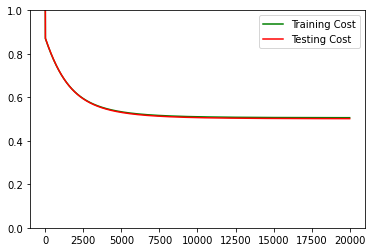

In [5]:
epochs = 20000
learning_rate = 0.005
hidden_nodes = 3

network = Neural_Network(epochs, learning_rate, hidden_nodes)
network.fit()